In [7]:
import torch.nn as nn
import torch
import numpy as np
import cv2
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from utils import *

%matplotlib inline

In [2]:

from torchvision.models import resnet18

In [8]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])])

In [9]:
img_path = r"D:\final_year_project\dataset_900\dataset1\A\Image_1687497782.009804.png"

In [10]:
img = cv2.imread(img_path)
img0 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

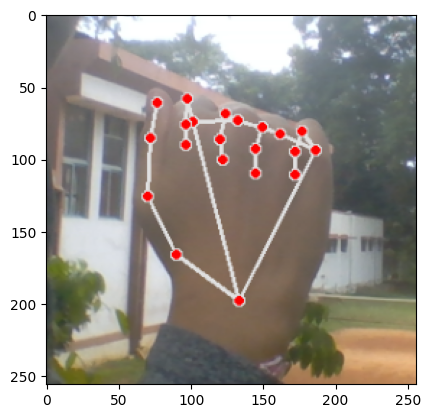

In [11]:
plt.imshow(img0)

In [13]:
img_tensor = img_transform(img0)
img_inp = img_tensor.unsqueeze(0)
img_inp.shape

torch.Size([1, 3, 256, 256])

In [12]:
backbone = "xception41"
weight_path = r"D:\final_year_project\weights2\fearless sweep-1\xception41_24.pt"
model = load_model(backbone, weight_path)

In [19]:
target_layers = [model.blocks[-1]]
input_tensor = img_inp

In [20]:
cam = GradCAM(model=model, target_layers=target_layers)

In [23]:
targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

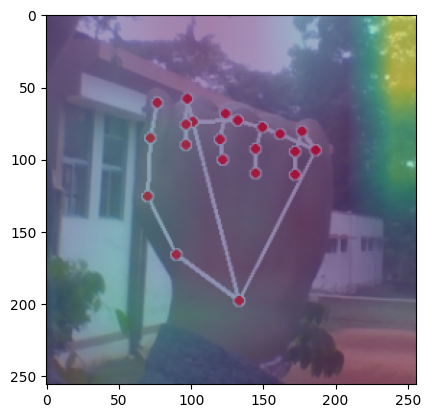

In [24]:
plt.imshow(img0)
plt.imshow(grayscale_cam, alpha = 0.5)

In [37]:
weight = r'"D:\final_year_project\weights2\fearless sweep-1\xception41_24.pt"'

model = resnet18(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model.load_state_dict(torch.load(weight))

c:\Users\thdam\miniconda3\envs\wsi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thdam\miniconda3\envs\wsi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [40]:
cam = GradCAM(model=model, target_layers=target_layers)

In [43]:
targets = [ClassifierOutputTarget(3)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

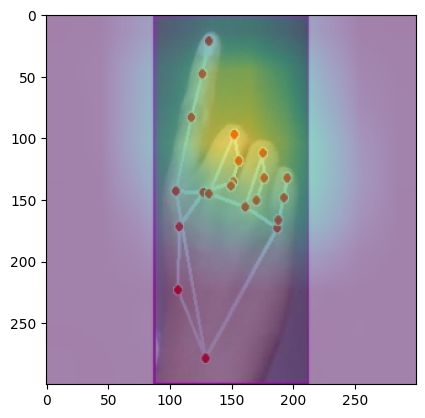

In [44]:
plt.imshow(img0)
plt.imshow(grayscale_cam, alpha = 0.5)

In [2]:
import torch.nn as nn
import torch
import numpy as np
import cv2
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import argparse
import os, glob
import timm
import sys
sys.path.append(r'D:\\final_year_project\\DiPASL')
from utils import *

c:\Users\thdam\miniconda3\envs\wsi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_folder = r'D:\final_year_project\gradcam\input1'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
path = r"D:\final_year_project\gradcam\input1\images\Image_1687858916.1465294.png"

img0 = cv2.imread(path)
img = cv2.cvtColor(img0, cv2.COLOR_RGB2BGR)

img_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    ], p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5172, 0.4853, 0.4789],
                        std = [0.2236, 0.2257, 0.2162]),
])

# plt.imshow(img)
# plt.show()
img_pil = Image.fromarray(np.uint8(img))
img_tensor = img_transform(img_pil)
img_inp = img_tensor.unsqueeze(0)#.to(device)
print(img_inp.shape)

torch.Size([1, 3, 256, 256])


In [66]:
input_tensor = img_tensor.unsqueeze(0)

In [4]:
def generate_layer(model, backbone):
    if backbone == 'rexnet_100':
        layer = [list(model.children())[1][-2].conv_exp.conv,
                 list(model.children())[1][-2].conv_dw.conv,
                 list(model.children())[1][-2].conv_pwl.conv,
                 list(model.children())[1][-1].conv]
    elif backbone == 'resnet18':
        layer = [model.layer4[0].conv1,
                 model.layer4[0].conv2,
                 model.layer4[-1].conv1,
                 model.layer4[-1].conv2]
    elif backbone == 'xception41':
        layer = [model.blocks[-1].stack.conv2.conv_dw,
                 model.blocks[-1].stack.conv2.conv_pw,
                 model.blocks[-1].stack.conv3.conv_dw,
                 model.blocks[-1].stack.conv3.conv_pw]
    else:
        layer = [model.blocks[-1][-1].conv_pw,
                 model.blocks[-1][-1].conv_dw,
                 model.blocks[-1][-1].conv_pwl,
                 model.conv_head]
    return layer

In [5]:
img_paths = glob.glob(os.path.join(input_folder, 'images', '*.png'))
weight_paths = glob.glob(os.path.join(input_folder, 'weights', '*.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for path in img_paths:
    fname = os.path.basename(path).split('.')[0]
    # print(fname)
    img0 = cv2.imread(path)
    img = cv2.cvtColor(img0, cv2.COLOR_RGB2BGR)
    
    img_transform = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        ], p=0.6),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5172, 0.4853, 0.4789],
                            std = [0.2236, 0.2257, 0.2162]),
    ])

    # plt.imshow(img)
    # plt.show()
    img_pil = Image.fromarray(np.uint8(img))
    img_tensor = img_transform(img_pil)
    img_inp = img_tensor.unsqueeze(0).to(device)
    
    for weight in weight_paths:
        backbone_name = os.path.basename(weight).split('_')[0]
        backbone = generate_backbone_name(backbone_name)
        model = load_model(backbone, weight, device)
        
        target_layer = generate_layer(model, backbone)
        print(target_layer)
        cam = GradCAM(model=model, target_layers=target_layer)
        targets = [ClassifierOutputTarget(0)]
        grayscale_cam = cam(input_tensor=img_inp, targets=targets, aug_smooth=True, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]

[Conv2d(328, 1968, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(1968, 1968, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1968, bias=False), Conv2d(1968, 328, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(328, 2152, kernel_size=(1, 1), stride=(1, 1), bias=False)]
[Conv2d(328, 1968, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(1968, 1968, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1968, bias=False), Conv2d(1968, 328, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(328, 2152, kernel_size=(1, 1), stride=(1, 1), bias=False)]
[Conv2d(328, 1968, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(1968, 1968, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1968, bias=False), Conv2d(1968, 328, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(328, 2152, kernel_size=(1, 1), stride=(1, 1), bias=False)]
[Conv2d(328, 1968, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(1968, 1968, kernel_size=(3, 3), stride=(1

In [5]:
# weight = r"D:\final_year_project\gradcam\input1\weights\efficientnetv2_rw_m_adamw_0.001_20.pt"

# "D:\final_year_project\gradcam\input1\weights\mobilenetv2_050_adamw_0.001_15.pt"
# "D:\final_year_project\gradcam\input1\weights\resnet18_sgd_0.01_15.pt"
# "D:\final_year_project\gradcam\input1\weights\rexnet_100_sgd_0.001_30.pt"
# "D:\final_year_project\gradcam\input1\weights\xception41_adam_0.0001_25.pt"

In [85]:
weight = r"D:\final_year_project\gradcam\input1\weights\rexnet_100_sgd_0.001_30.pt"

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone_name = 'rexnet'
backbone = generate_backbone_name(backbone_name)
model = load_model(backbone, weight, torch.device("cpu"))

In [87]:
backbone

'rexnet_100'

In [88]:
model

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [98]:
list(model.children())[1][-2]

LinearBottleneck(
  (conv_exp): ConvNormAct(
    (conv): Conv2d(174, 1044, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      1044, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (conv_dw): ConvNormAct(
    (conv): Conv2d(1044, 1044, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1044, bias=False)
    (bn): BatchNormAct2d(
      1044, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
  )
  (se): SEModule(
    (fc1): Conv2d(1044, 87, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(87, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
    (fc2): Conv2d(87, 1044, kernel_size=(1, 1), stride=(1, 1))
    (gate): Sigmoid()
  )
  (act_dw): ReLU6()
  (conv_pwl): ConvNormAct(
    (conv): Conv2d(1044, 185, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [102]:
list(model.children())[1][-2].conv_dw.conv

Conv2d(1044, 1044, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1044, bias=False)

In [97]:
list(model.children())[1][-1].conv

Conv2d(185, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [103]:
target_layer = [list(model.children())[1][-2].conv_exp.conv, list(model.children())[1][-2].conv_dw.conv, list(model.children())[1][-2].conv_pwl.conv, list(model.children())[1][-1].conv] #rexnet

In [79]:
target_layer = [model.blocks[-1].stack.conv2.conv_dw, model.blocks[-1].stack.conv2.conv_pw, model.blocks[-1].stack.conv3.conv_dw, model.blocks[-1].stack.conv3.conv_pw] #xception

In [63]:
target_layer = [model.blocks[-1][-1].conv_pw, model.blocks[-1][-1].conv_dw, model.blocks[-1][-1].conv_pwl, model.conv_head] #efficientnet #mobilenet

In [27]:
target_layer = [model.layer4[0].conv1, model.layer4[0].conv2, model.layer4[-1].conv1, model.layer4[-1].conv2] #resnet

In [104]:
cam = GradCAM(model=model, target_layers=target_layer)

In [105]:
targets = [ClassifierOutputTarget(0)]

In [106]:
grayscale_cam = cam(input_tensor=img_inp, targets=targets, aug_smooth=True, eigen_smooth=True)

In [107]:
grayscale_cam = grayscale_cam[0, :]

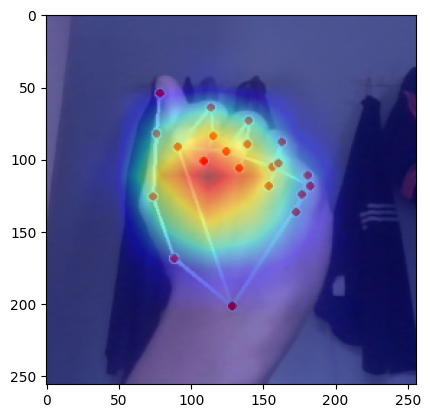

In [108]:
plt.imshow(img)
plt.imshow(grayscale_cam, alpha = 0.5, cmap = 'jet')